In [84]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [85]:
import numpy as np
import pandas as pd

In [86]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [87]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [88]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [89]:
# reflect an existing database into a new model
Base = automap_base()

In [90]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [91]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [92]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [93]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [94]:
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

# Exploratory Climate Analysis

In [95]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
climate_precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

In [96]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_precipitation_df = pd.DataFrame(climate_precipitation_data, columns = ['date', 'precipitation'])

In [97]:
# Sort the dataframe by date
#set index
climate_precipitation_df.set_index('date', inplace=True)
# Sort the dataframe by date
climate_precipitation_df = climate_precipitation_df.sort_values(by='date')
climate_precipitation_df.head()

precipitation
date                     
2016-08-23           0.00
2016-08-23            NaN
2016-08-23           1.79
2016-08-23           0.05
2016-08-23           0.15

In [98]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20, 10))
climate_precipitation_df.plot(ax = ax, x_compat = True)

ax.set_xlabel = ('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation")

plt.savefig("Images/climate_precipitation.png")

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Images/climate_precipitation.png'

In [99]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_precipitation_df.describe()

precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

In [100]:
# Design a query to show how many stations are available in this dataset?
station = session.query(func.count(Station.station)).all()
station

[(9)]

In [101]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station = session.query(Measurement.station,func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
station 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [111]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*active_station).filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [115]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station=session.query(Measurement.tobs).filter(Measurement.station==active_station)\
.filter(Measurement.date>= max_date).all()

temp_obs_df = pd.DataFrame(station, columns = ['date', 'temperature'])

#Plot Graph
plt.hist(results, bins=12)
plt.xlabel('Temperature Â°F')
plt.ylabel('Frequency Count')
plt.title(f'Temperature Count for Station: {active_station}')
plt.legend('Temperature')
plt.show()

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 0 - probably unsupported type.
[SQL: SELECT measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ?]
[parameters: ([<sqlalchemy.sql.functions.min at 0x1f73ce07e48; min>, <sqlalchemy.sql.functions.max at 0x1f73d2cc7b8; max>, <sqlalchemy.sql.functions.Function at 0x1f73d2cc518; avg>], [('2017-08-23',)])]
(Background on this error at: http://sqlalche.me/e/13/rvf5)

## Bonus Challenge Assignment

In [116]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [117]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-04-21', '2017-04-28')
temps

[(67.0, 74.64, 81.0)]

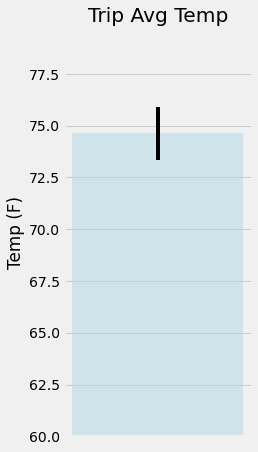

In [118]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,7))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='lightblue', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
